##### Copyright 2020 Google LLC.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# NOTE: Due to the constraints of the /google_research/ repo, this package is
# assumes that it is being called from the folder above this one. Because
# of this, this notebook needs modify the system path to include the path
# above it. This should not be necessary when using this library elsewhere
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)
import robust_loss.general
import robust_loss.adaptive

# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = tf.convert_to_tensor(x, tf.float32)
y = tf.convert_to_tensor(y, tf.float32)


class RegressionModel(tf.Module):
  # A simple linear regression module.
  def __init__(self):
    self.w = tf.Variable(0.)
    self.b = tf.Variable(0.)

  def __call__(self, z):
    return self.w * z + self.b


def plot_regression(regression):
  # A helper function for plotting a regression module.
  x_plot = np.float32(np.linspace(0, 1, 100))
  y_plot = regression(tf.convert_to_tensor(x_plot)).numpy()
  y_plot_true = x_plot * scale_true + shift_true

  plt.figure(0, figsize=(4, 4))
  plt.scatter(x, y)
  plt.plot(x_plot, y_plot_true, color='k')
  plt.plot(x_plot, y_plot, color='r')

0   : loss=13.92873
50  : loss=1.78875
100 : loss=1.67389
150 : loss=1.67370
200 : loss=1.67375
250 : loss=1.67372
300 : loss=1.67424
350 : loss=1.67373
400 : loss=1.67391
450 : loss=1.67377
500 : loss=1.67382
550 : loss=1.67370
600 : loss=1.67370
650 : loss=1.67370
700 : loss=1.67521
750 : loss=1.67386
800 : loss=1.67425
850 : loss=1.67382
900 : loss=1.67464
950 : loss=1.67372
1000: loss=1.67403


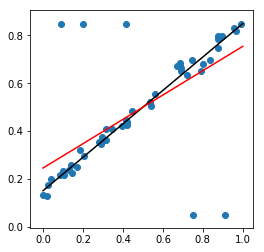

In [0]:
# Fit a linear regression using mean squared error.
regression = RegressionModel()
variables = regression.trainable_variables
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.5, beta_2=0.9, epsilon=1e-08)

for epoch in range(1001):

  def lossfun():
    # Hijacking the general loss to compute MSE.
    return tf.reduce_mean(
        robust_loss.general.lossfun(y - regression(x), alpha=2., scale=0.1))

  optimizer.minimize(lossfun, variables)
  if np.mod(epoch, 50) == 0:
    print('{:<4}: loss={:0.5f}'.format(epoch, lossfun()))

# It doesn't fit well.
plot_regression(regression)

0   : loss=+1.30600  alpha=1.00500  scale=0.99369
50  : loss=+0.81370  alpha=1.24806  scale=0.69965
100 : loss=+0.41574  alpha=1.46083  scale=0.47681
150 : loss=+0.03641  alpha=1.62745  scale=0.31602
200 : loss=-0.25180  alpha=1.73791  scale=0.20793
250 : loss=-0.37724  alpha=1.64325  scale=0.14308
300 : loss=-0.45471  alpha=1.44397  scale=0.11082
350 : loss=-0.55913  alpha=1.20640  scale=0.08612
400 : loss=-0.71528  alpha=0.94550  scale=0.06072
450 : loss=-0.91360  alpha=0.69710  scale=0.04031
500 : loss=-1.11517  alpha=0.49126  scale=0.02743
550 : loss=-1.27192  alpha=0.33634  scale=0.02091
600 : loss=-1.37283  alpha=0.22587  scale=0.01729
650 : loss=-1.43477  alpha=0.14965  scale=0.01529
700 : loss=-1.47247  alpha=0.09828  scale=0.01377
750 : loss=-1.49214  alpha=0.06422  scale=0.01310
800 : loss=-1.50190  alpha=0.04189  scale=0.01264
850 : loss=-1.50135  alpha=0.02733  scale=0.01239
900 : loss=-1.50108  alpha=0.01790  scale=0.01227
950 : loss=-1.51328  alpha=0.01181  scale=0.01207


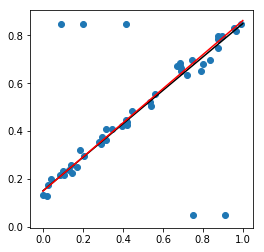

In [0]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel()
adaptive_lossfun = (
    robust_loss.adaptive.AdaptiveLossFunction(
        num_channels=1, float_dtype=np.float32))
variables = (
    list(regression.trainable_variables) +
    list(adaptive_lossfun.trainable_variables))
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.5, beta_2=0.9, epsilon=1e-08)

for epoch in range(1001):

  def lossfun():
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape
    # and scale parameter per dimension (and there's only one dimension for
    # this data).
    return tf.reduce_mean(adaptive_lossfun((y - regression(x))[:, None]))

  optimizer.minimize(lossfun, variables)
  if np.mod(epoch, 50) == 0:
    loss = lossfun()
    alpha = adaptive_lossfun.alpha()[0, 0]
    scale = adaptive_lossfun.scale()[0, 0]
    print('{:<4}: loss={:+0.5f}  alpha={:0.5f}  scale={:0.5f}'.format(
        epoch, loss, alpha, scale))

# It fits!
plot_regression(regression)